In [1]:
# Standard Libraries
import argparse
import os
import sys
from tqdm import tqdm

# Python Modules
from collections import Counter
from dataclasses import dataclass
from typing import NamedTuple
from collections import namedtuple
import gc

# Type Hint Libraries
from typing import Optional, Tuple, Union, TypeVar, List
import numpy.typing as npt
import matplotlib.figure
from torch import Tensor

# Math and Data Science Libraries
import numpy as np
import pandas as pd
from scipy.ndimage.filters import convolve

# Plot Libraries
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton

# Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader


# Image Libraries
import cv2

import skimage as ski
from skimage import io
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
from skimage.color import hsv2rgb

# User defined methods and classes
sys.path.insert(0,'/content/drive/MyDrive/')

<ipython-input-1-a738c95dbd0d>:23: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [2]:
from utils import parse_line
from utils import lines_to_polygons
from utils import build_mask_dataset
from utils import mask_in_set
from utils import nodes_to_points
from utils import plot_image_and_mask
from utils import create_binary_mask

from Unet_model import UNET

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
# Path to dataset
DATA_PATH = '/content/drive/MyDrive/PNG/'
# Creating a path to save masks
MASKS_PATH = '/content/drive/MyDrive/masks/'
# Creating a path to save model
MODEL_PATH = '/content/drive/MyDrive/model/unet_weigths_v6.pth'

In [5]:
# Creates a list of the *.png file names in the dataset
image_files = os.listdir(DATA_PATH)

In [6]:
image_names = []

for file_name in image_files:
    image_names.append(file_name.replace('.png',''))

In [7]:
print(len(image_names))
image_names = image_names[:1351]

1705


In [8]:
train_image_names, test_image_names, _, _ = train_test_split(image_names, image_names, test_size=0.2, random_state=42)

In [9]:
train_images = []
test_images = []
train_masks = []
test_masks = []

In [10]:
# Loading train images as grayscale images
for name in train_image_names:
    full_path = DATA_PATH + name + '.png'
    curr_image = io.imread(full_path)
    train_images.append(rgb2gray(curr_image))

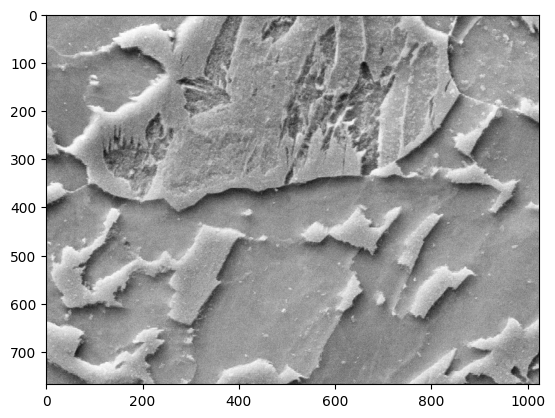

In [11]:
# Testing images were loaded correctly
plt.imshow(train_images[0], cmap=plt.cm.gray)
plt.show()

In [12]:
print('Image shape:         ',train_images[0].shape)
print('Element type:        ',train_images[0].dtype)
print('Data structure type: ',type(train_images[0]))
print('Max. value:          ',np.max(train_images[0]))
print('Min. value:          ',np.min(train_images[0]))
print('Length images:       ',len(train_images))

Image shape:          (768, 1024)
Element type:         float64
Data structure type:  <class 'numpy.ndarray'>
Max. value:           0.996078431372549
Min. value:           0.06666666666666667
Length images:        1080


In [13]:
# Loading train masks as grayscale images
for name in train_image_names:
    full_path = MASKS_PATH + name + '.jpg'
    curr_mask = io.imread(full_path)
    train_masks.append(rgb2gray(curr_mask).round())

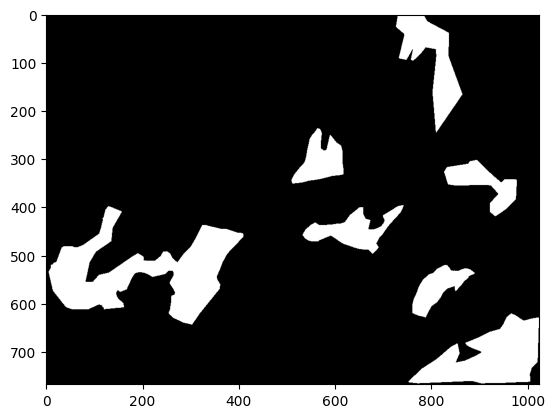

In [14]:
# Testing images were loaded correctly
plt.imshow(train_masks[0], cmap=plt.cm.gray)
plt.show()

In [15]:
print('Image shape:         ',train_masks[0].shape)
print('Element type:        ',train_masks[0].dtype)
print('Data structure type: ',type(train_masks[0]))
print('Max. value:          ',np.max(train_masks[0]))
print('Min. value:          ',np.min(train_masks[0]))
print('Length masks:        ',len(train_masks))

Image shape:          (768, 1024)
Element type:         float64
Data structure type:  <class 'numpy.ndarray'>
Max. value:           1.0
Min. value:           0.0
Length masks:         1080


In [16]:
# Loading test images as grayscale images
for name in test_image_names:
    full_path = DATA_PATH + name + '.png'
    curr_image = io.imread(full_path)
    test_images.append(rgb2gray(curr_image))

In [17]:
# Loading test images as grayscale images
for name in test_image_names:
    full_path = MASKS_PATH + name + '.jpg'
    curr_mask = io.imread(full_path)
    test_masks.append(rgb2gray(curr_mask).round())

First I created a custom Dataset class for this particular dataset:

In [18]:
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, images: list, masks: list):
        super(DataLoaderSegmentation, self).__init__()
        assert len(images) == len(masks), 'Length of image list must be the same of masks list'
        self.img = np.array(images)
        self.msk = np.array(masks)

    def __getitem__(self, index)->Tuple[Tensor]:
            data = self.img[index]
            label = self.msk[index]
            return torch.unsqueeze(torch.from_numpy(data).float(),0), torch.unsqueeze(torch.from_numpy(label).float(),0)

    def __len__(self):
        return len(self.img)

In [19]:
train_dataset = DataLoaderSegmentation(train_images,train_masks)
test_dataset = DataLoaderSegmentation(test_images,test_masks)

Next step is creating a dataloader for the network

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

Model

In [21]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4                                          # Paper uses lr=2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # Paper uses 20
NUM_EPOCHS = 3                                                # Paper uses 1e10 if
NUM_WORKERS = 2                                               # paper uses 0
IMAGE_HEIGHT = 768
IMAGE_WIDTH = 1024
PIN_MEMORY = True
LOAD_MODEL = False
loss_fn = torch.nn.BCEWithLogitsLoss()                        # Paper uses losses.DiceBCELoss(weight=0.7)
scaler = torch.cuda.amp.GradScaler()
model = UNET().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Paper uses Adam
# metrics = [smp.utils.metrics.IoU(threshold=0.5),]           # Coming from the paper

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    loop = tqdm(dataloader)

    loss_20_batches = 0
    loss_epoch = 0

    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    for batch, (image, mask) in enumerate(loop):

        image = image.to(DEVICE)
        mask = mask.to(DEVICE)

        with torch.cuda.amp.autocast(): # Mod
            # Compute prediction and loss
            pred = model(image)
            loss = loss_fn(pred, mask)
            loss_20_batches += loss
            loss_epoch += loss

        # Backpropagation Mod
        optimizer.zero_grad()         # Original 1: loss.backward()
        scaler.scale(loss.to(DEVICE)).backward() # Original 2: optimizer.step()
        scaler.step(optimizer)        # Original 3: optimizer.zero_grad()
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

        if batch % 20 == 0:
            loop.set_postfix(loss_20_batches=loss_20_batches.item()/20)
            loss_20_batches = 0

    print(f"==> training_loss: {loss_epoch/len(dataloader):2f}")

In [23]:
def test_loop(dataloader, model, loss_fn):

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    loss_epoch = 0

    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True

    with torch.no_grad():
        for batch, (image, mask) in enumerate(dataloader):

            image = image.to(DEVICE)
            mask = mask.to(DEVICE)

            pred = model(image)

            loss_epoch += loss_fn(pred, mask)
            mask_pred = torch.sigmoid(pred)
            mask_pred = (mask_pred > 0.5).float()

            num_correct += (mask_pred == mask).sum()
            num_pixels += torch.numel(mask_pred)
            dice_score += (2 * (mask_pred * mask).sum()) / (
                    (mask_pred + mask).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {(num_correct/num_pixels)*100:.2f}"
    )
    print(
        f"==> valuation_loss: {loss_epoch/len(dataloader):2f}"
    )

    print(f"==> dice_score: {dice_score/len(dataloader)}")

    model.train()

In [24]:
DEVICE

'cuda'

In [25]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 68/68 [01:21<00:00,  1.20s/it, loss=0.359]


==> training_loss: 0.450078
Got 186408409/213123072 with acc 87.47
==> valuation_loss: 0.400315
==> dice_score: 0.41219305992126465
Epoch 2
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.311]


==> training_loss: 0.324112
Got 197593319/213123072 with acc 92.71
==> valuation_loss: 0.322941
==> dice_score: 0.5264354944229126
Epoch 3
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.292]


==> training_loss: 0.292965
Got 198331460/213123072 with acc 93.06
==> valuation_loss: 0.292011
==> dice_score: 0.5179935097694397
Epoch 4
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.25]


==> training_loss: 0.265279
Got 188712314/213123072 with acc 88.55
==> valuation_loss: 0.321413
==> dice_score: 0.4604109525680542
Epoch 5
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.216]


==> training_loss: 0.246499
Got 200628775/213123072 with acc 94.14
==> valuation_loss: 0.243552
==> dice_score: 0.5182652473449707
Epoch 6
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.205]


==> training_loss: 0.227394
Got 201246378/213123072 with acc 94.43
==> valuation_loss: 0.227727
==> dice_score: 0.5436099171638489
Epoch 7
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.26]


==> training_loss: 0.213697
Got 200757110/213123072 with acc 94.20
==> valuation_loss: 0.217312
==> dice_score: 0.5248571038246155
Epoch 8
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.176]


==> training_loss: 0.204332
Got 201265857/213123072 with acc 94.44
==> valuation_loss: 0.196831
==> dice_score: 0.49262821674346924
Epoch 9
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.172]


==> training_loss: 0.190626
Got 201557141/213123072 with acc 94.57
==> valuation_loss: 0.193926
==> dice_score: 0.5563000440597534
Epoch 10
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.168]


==> training_loss: 0.182999
Got 201510299/213123072 with acc 94.55
==> valuation_loss: 0.179721
==> dice_score: 0.5080710053443909
Epoch 11
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.146]


==> training_loss: 0.173630
Got 201115717/213123072 with acc 94.37
==> valuation_loss: 0.178556
==> dice_score: 0.4566080868244171
Epoch 12
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.147]


==> training_loss: 0.166190
Got 199418760/213123072 with acc 93.57
==> valuation_loss: 0.182810
==> dice_score: 0.2199140191078186
Epoch 13
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.143]


==> training_loss: 0.162418
Got 201037186/213123072 with acc 94.33
==> valuation_loss: 0.173694
==> dice_score: 0.5832788944244385
Epoch 14
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.131]


==> training_loss: 0.154757
Got 199887119/213123072 with acc 93.79
==> valuation_loss: 0.181776
==> dice_score: 0.6034290194511414
Epoch 15
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.153]


==> training_loss: 0.149358
Got 200632937/213123072 with acc 94.14
==> valuation_loss: 0.168527
==> dice_score: 0.5778326392173767
Epoch 16
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.131]


==> training_loss: 0.148027
Got 201171643/213123072 with acc 94.39
==> valuation_loss: 0.155554
==> dice_score: 0.4587588310241699
Epoch 17
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.124]


==> training_loss: 0.141022
Got 201378636/213123072 with acc 94.49
==> valuation_loss: 0.153812
==> dice_score: 0.582653284072876
Epoch 18
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.141]


==> training_loss: 0.136966
Got 201504751/213123072 with acc 94.55
==> valuation_loss: 0.153781
==> dice_score: 0.528819739818573
Epoch 19
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.144]


==> training_loss: 0.131457
Got 200690850/213123072 with acc 94.17
==> valuation_loss: 0.152337
==> dice_score: 0.411304771900177
Epoch 20
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.142]


==> training_loss: 0.128922
Got 201541086/213123072 with acc 94.57
==> valuation_loss: 0.147465
==> dice_score: 0.555076003074646
Epoch 21
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.113]


==> training_loss: 0.120499
Got 201014500/213123072 with acc 94.32
==> valuation_loss: 0.149819
==> dice_score: 0.5203408598899841
Epoch 22
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.116]


==> training_loss: 0.115833
Got 201296048/213123072 with acc 94.45
==> valuation_loss: 0.143789
==> dice_score: 0.557815432548523
Epoch 23
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.122]


==> training_loss: 0.108560
Got 200276486/213123072 with acc 93.97
==> valuation_loss: 0.164631
==> dice_score: 0.5914266705513
Epoch 24
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0902]


==> training_loss: 0.102032
Got 198840958/213123072 with acc 93.30
==> valuation_loss: 0.178298
==> dice_score: 0.568859875202179
Epoch 25
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.107]


==> training_loss: 0.096282
Got 200671552/213123072 with acc 94.16
==> valuation_loss: 0.162322
==> dice_score: 0.5804448127746582
Epoch 26
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0728]


==> training_loss: 0.088180
Got 200926573/213123072 with acc 94.28
==> valuation_loss: 0.155345
==> dice_score: 0.5439083576202393
Epoch 27
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0785]


==> training_loss: 0.079454
Got 199441363/213123072 with acc 93.58
==> valuation_loss: 0.176843
==> dice_score: 0.5600917935371399
Epoch 28
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0745]


==> training_loss: 0.074702
Got 200809618/213123072 with acc 94.22
==> valuation_loss: 0.169004
==> dice_score: 0.4976835250854492
Epoch 29
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0604]


==> training_loss: 0.068775
Got 200552550/213123072 with acc 94.10
==> valuation_loss: 0.167416
==> dice_score: 0.5588359236717224
Epoch 30
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0627]


==> training_loss: 0.062152
Got 200097917/213123072 with acc 93.89
==> valuation_loss: 0.180716
==> dice_score: 0.5848323106765747
Epoch 31
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.048]


==> training_loss: 0.054539
Got 200468234/213123072 with acc 94.06
==> valuation_loss: 0.180208
==> dice_score: 0.5721278786659241
Epoch 32
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0554]


==> training_loss: 0.054651
Got 200140896/213123072 with acc 93.91
==> valuation_loss: 0.182432
==> dice_score: 0.5377317070960999
Epoch 33
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0553]


==> training_loss: 0.050911
Got 200640772/213123072 with acc 94.14
==> valuation_loss: 0.184885
==> dice_score: 0.49628448486328125
Epoch 34
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0487]


==> training_loss: 0.047002
Got 199436224/213123072 with acc 93.58
==> valuation_loss: 0.194537
==> dice_score: 0.5709131360054016
Epoch 35
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0472]


==> training_loss: 0.049507
Got 187217021/213123072 with acc 87.84
==> valuation_loss: 0.316648
==> dice_score: 0.3763117790222168
Epoch 36
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0405]


==> training_loss: 0.045404
Got 200526827/213123072 with acc 94.09
==> valuation_loss: 0.190508
==> dice_score: 0.5502805709838867
Epoch 37
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0314]


==> training_loss: 0.040566
Got 199275194/213123072 with acc 93.50
==> valuation_loss: 0.203666
==> dice_score: 0.5786528587341309
Epoch 38
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0322]


==> training_loss: 0.038350
Got 200687950/213123072 with acc 94.17
==> valuation_loss: 0.200174
==> dice_score: 0.4926507771015167
Epoch 39
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.038]


==> training_loss: 0.036328
Got 201161369/213123072 with acc 94.39
==> valuation_loss: 0.202585
==> dice_score: 0.5360917448997498
Epoch 40
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0328]


==> training_loss: 0.034907
Got 200853711/213123072 with acc 94.24
==> valuation_loss: 0.212167
==> dice_score: 0.5004242658615112
Epoch 41
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0395]


==> training_loss: 0.033064
Got 200511789/213123072 with acc 94.08
==> valuation_loss: 0.214048
==> dice_score: 0.5831603407859802
Epoch 42
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0293]


==> training_loss: 0.032579
Got 200964415/213123072 with acc 94.30
==> valuation_loss: 0.203707
==> dice_score: 0.5480414628982544
Epoch 43
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0292]


==> training_loss: 0.030539
Got 200696833/213123072 with acc 94.17
==> valuation_loss: 0.210215
==> dice_score: 0.5455937385559082
Epoch 44
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0354]


==> training_loss: 0.029506
Got 201307032/213123072 with acc 94.46
==> valuation_loss: 0.205830
==> dice_score: 0.5597856044769287
Epoch 45
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0321]


==> training_loss: 0.029745
Got 200958351/213123072 with acc 94.29
==> valuation_loss: 0.218747
==> dice_score: 0.4779013395309448
Epoch 46
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0397]


==> training_loss: 0.033578
Got 200128027/213123072 with acc 93.90
==> valuation_loss: 0.216268
==> dice_score: 0.5728132128715515
Epoch 47
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0228]


==> training_loss: 0.029215
Got 200939204/213123072 with acc 94.28
==> valuation_loss: 0.222134
==> dice_score: 0.4964306652545929
Epoch 48
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.042]


==> training_loss: 0.026983
Got 200105379/213123072 with acc 93.89
==> valuation_loss: 0.220902
==> dice_score: 0.5634036660194397
Epoch 49
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0232]


==> training_loss: 0.026303
Got 200894883/213123072 with acc 94.26
==> valuation_loss: 0.217981
==> dice_score: 0.49363529682159424
Epoch 50
-------------------------------


100%|██████████| 68/68 [01:46<00:00,  1.57s/it, loss=0.0244]


==> training_loss: 0.027044
Got 200301706/213123072 with acc 93.98
==> valuation_loss: 0.228714
==> dice_score: 0.46342578530311584
Done!


In [26]:
torch.save(model.state_dict(), MODEL_PATH)

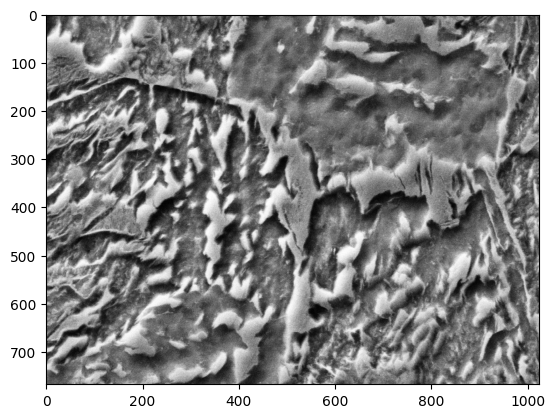

In [27]:
# Testing images were loaded correctly
plt.imshow(train_images[11], cmap=plt.cm.gray)
plt.show()

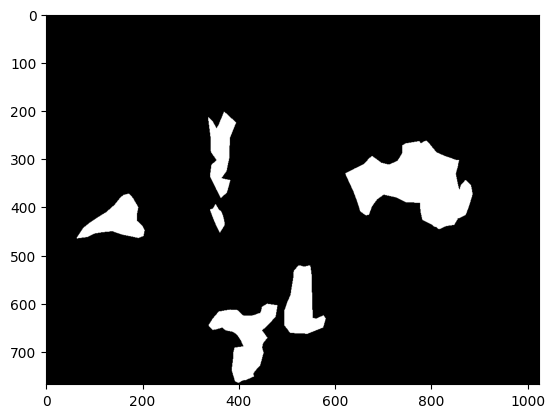

In [28]:
# Testing images were loaded correctly
plt.imshow(train_masks[11], cmap=plt.cm.gray)
plt.show()

In [29]:
test_im = train_masks[11]
test_im = torch.tensor(test_im).unsqueeze(dim=0).unsqueeze(dim=0).float()
test_im.shape

torch.Size([1, 1, 768, 1024])

In [30]:
pred = model(test_im.to(DEVICE))

In [31]:
pred.shape

torch.Size([1, 1, 768, 1024])

In [32]:
mask_pred = torch.sigmoid(pred)
mask_pred = (mask_pred > 0.5).float()

In [33]:
a = Tensor.cpu(pred.squeeze(dim=0).squeeze(dim=0)).detach().numpy()
a

array([[-4.3869348, -6.874966 , -6.8833666, ..., -6.4632845, -6.003725 ,
        -5.464734 ],
       [-6.298807 , -9.195215 , -9.211683 , ..., -8.724157 , -8.169382 ,
        -6.3228903],
       [-5.946211 , -9.170772 , -9.242937 , ..., -9.13806  , -8.572512 ,
        -6.517178 ],
       ...,
       [-6.438404 , -9.3239975, -9.574431 , ..., -9.595568 , -9.5606   ,
        -7.493284 ],
       [-6.3123493, -9.090339 , -9.237868 , ..., -9.340968 , -9.347809 ,
        -6.8994794],
       [-5.38396  , -7.098449 , -7.2133923, ..., -7.4391866, -7.2566   ,
        -5.5603576]], dtype=float32)

In [34]:
b = Tensor.cpu(mask_pred.squeeze(dim=0).squeeze(dim=0)).detach().numpy()
b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

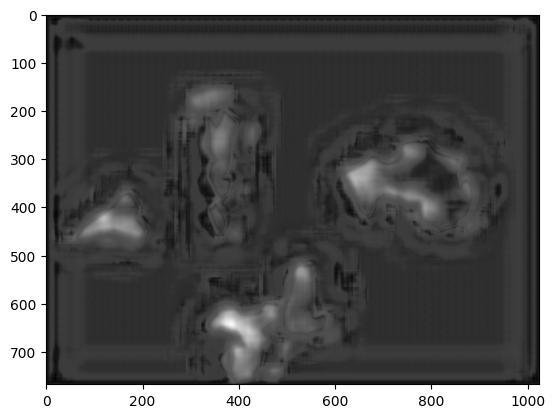

In [35]:
# Visualizing predicted mask
plt.imshow(a, cmap=plt.cm.gray)
plt.show()

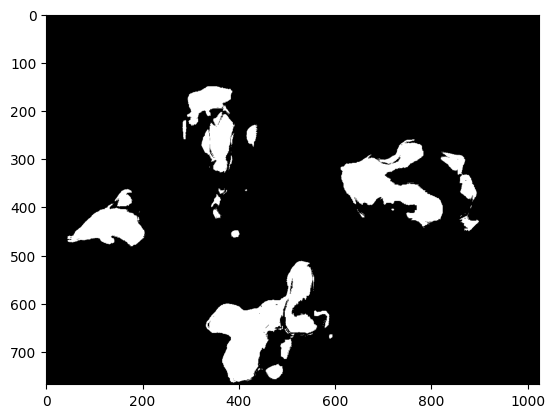

In [36]:
# Visualizing predicted mask
plt.imshow(b, cmap=plt.cm.gray)
plt.show()